Device: cuda
Loading model deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B ...
Model has 28 layers
Loading dataset...

Starting processing batches...


100%|██████████| 8/8 [00:57<00:00,  7.21s/it]



--- Results (averaged across batches = 8) ---
Layer |   Param Strain (E_l) |   Belief Change (Δp_l) |    Semantic Efficiency
-------------------------------------------------------------------------------------
    1 |         3.611492e+03 |           1.106028e+00 |               0.332379
    2 |         6.092400e+02 |           1.144386e+00 |               1.343381
    3 |         5.812019e+02 |           1.118447e+00 |               1.349771
    4 |         3.993219e+02 |           1.137261e+00 |               1.732089
    5 |         2.896822e+02 |           1.070320e+00 |               1.985279
    6 |         2.548627e+02 |           1.046277e+00 |               2.103022
    7 |         2.097890e+02 |           1.028397e+00 |               2.339923
    8 |         1.855336e+02 |           9.433815e-01 |               2.346845
    9 |         1.551077e+02 |           8.871055e-01 |               2.519116
   10 |         1.564725e+02 |           8.360676e-01 |               2.34272

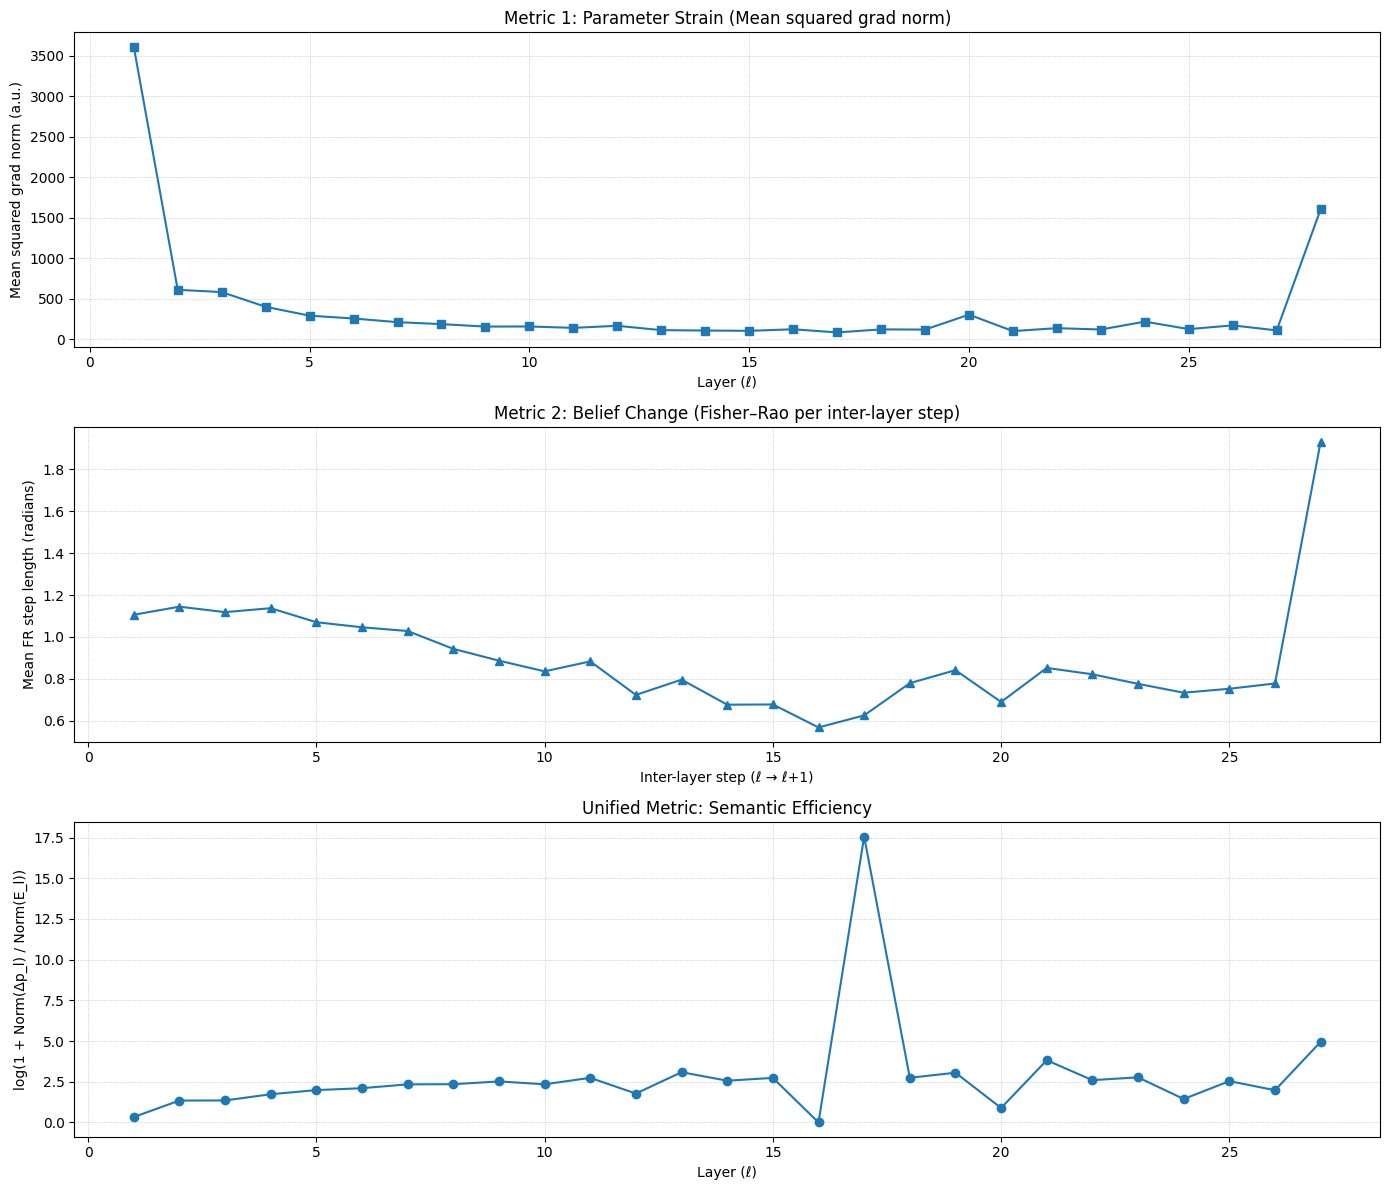

In [11]:
# DeepSeek-R1 1.5B — per-layer squared grad norms + Fisher–Rao & Semantic Efficiency
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# -----------------------
# Config (tune for memory)
# -----------------------
MODEL_NAME  = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE  = 2
NUM_BATCHES = 8       # number of data batches to process
MAX_LEN     = 128
DATA_SLICE  = "train[:1%]"

print("Device:", DEVICE)

# -----------------------
# Load model + tokenizer
# -----------------------
print(f"Loading model {MODEL_NAME} ...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if DEVICE == "cuda" else torch.float32,
    device_map="auto" if DEVICE == "cuda" else None,
)
model.train()  # we will compute grads
blocks = model.model.layers
final_ln = model.model.norm
lm_head = model.lm_head
num_layers = len(blocks)
print(f"Model has {num_layers} layers")

# -----------------------
# Dataset (small slice)
# -----------------------
print("Loading dataset...")
ds = load_dataset("wikitext", "wikitext-2-raw-v1", split=DATA_SLICE)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, max_length=MAX_LEN, padding="max_length")

ds = ds.map(tokenize_fn, batched=True, remove_columns=["text"])
ds.set_format(type="torch", columns=["input_ids", "attention_mask"])
loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

# -----------------------
# Accumulators
# -----------------------
layer_grad_sums = torch.zeros(num_layers, device="cpu")           # sum of squared grad norm per layer
fr_step_sums     = torch.zeros(num_layers - 1, device="cpu")     # sums of FR step lengths (per inter-layer)
fr_step_counts   = torch.zeros(num_layers - 1, device="cpu")     # counts of valid tokens per inter-layer
processed_batches = 0

print("\nStarting processing batches...")

# -----------------------
# Helper for FR step between logprobs
# -----------------------
@torch.no_grad()
def fr_step_from_logprobs(logp_prev, logp_next, valid_mask):
    # logp_prev/logp_next: (B, S, V)
    # valid_mask: (B, S) boolean
    s = 0.5 * (logp_prev + logp_next)            # (B, S, V)
    log_bc = torch.logsumexp(s, dim=-1)         # (B, S)
    bc = torch.exp(log_bc).clamp(0.0, 1.0)      # (B, S)
    steps = 2.0 * torch.acos(bc)                # (B, S)
    if valid_mask is not None:
        steps = steps.masked_fill(~valid_mask, 0.0)
    return steps                                  # (B, S)

# -----------------------
# Main loop: forward once per batch -> compute per-layer grads & FR
# -----------------------
use_autocast = (DEVICE == "cuda")
amp_dtype = torch.bfloat16 if use_autocast else torch.float32

for batch in tqdm(loader, total=NUM_BATCHES):
    if processed_batches >= NUM_BATCHES:
        break
    processed_batches += 1

    # move inputs
    input_ids = batch["input_ids"].to(DEVICE)
    attention_mask = batch["attention_mask"].to(DEVICE).to(torch.bool)  # bool for attention

    # labels for next-token prediction (causal)
    labels = input_ids.clone()
    if tokenizer.pad_token_id is not None:
        labels[labels == tokenizer.pad_token_id] = -100
    else:
        labels[labels == 0] = -100

    # single forward that returns hidden states for each layer (embeddings + per-layer outputs)
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        output_hidden_states=True,
        return_dict=True,
    )
    hidden_states = outputs.hidden_states  # tuple: (embeddings, layer1_out, ..., layerL_out)

    # We'll compute per-layer loss/grads and log-probs for FR
    logp_prev = None
    valid_mask = (labels != -100)  # (B, S) boolean

    for i, block in enumerate(blocks):
        # hidden_states[i+1] is output of block i
        h_i = hidden_states[i + 1]            # (B, S, H)

        # compute logits & log-probs for FR
        with torch.no_grad():
            logits_i = lm_head(final_ln(h_i)).float()      # (B, S, V) in float for stable softmax
            logp_i = F.log_softmax(logits_i, dim=-1)      # (B, S, V)

        # accumulate Fisher-Rao step between previous layer and this one (if prev exists)
        if logp_prev is not None:
            steps = fr_step_from_logprobs(logp_prev, logp_i, valid_mask)  # (B, S)
            fr_step_sums[i - 1] += steps.sum().cpu()
            fr_step_counts[i - 1] += valid_mask.sum().cpu()

        # keep logp for next iteration
        logp_prev = logp_i

        # --- compute gradient contribution for this layer ---
        # build loss from this layer's logits (we need gradient graph for params)
        logits_i_for_loss = lm_head(final_ln(h_i))   # keep dtype as model dtype (may be bfloat16)
        loss_i = F.cross_entropy(
            logits_i_for_loss.view(-1, logits_i_for_loss.size(-1)),
            labels.view(-1),
            ignore_index=-100,
            reduction="mean",
        )

        # parameters belonging to this block
        params = [p for p in block.parameters() if p.requires_grad]
        if len(params) > 0:
            grads = torch.autograd.grad(loss_i, params, retain_graph=True, allow_unused=True)
            # squared norm sum
            g2 = 0.0
            for g in grads:
                if g is None:
                    continue
                # move to CPU and sum squares
                g2 += float((g.detach() ** 2).sum().cpu().item())
            layer_grad_sums[i] += g2
        else:
            # unlikely; leave 0
            pass

    # cleanup to free memory for next batch
    del outputs, hidden_states
    torch.cuda.empty_cache()

# -----------------------
# Finalize metrics
# -----------------------
mean_layer_grad_sq = (layer_grad_sums / max(1, processed_batches)).numpy()   # length = num_layers
fr_step_means = (fr_step_sums / fr_step_counts.clamp_min(1)).numpy()       # length = num_layers - 1

# Semantic efficiency: align param strain (layer i) with belief change (i -> i+1)
param_strain_matched = mean_layer_grad_sq[: len(fr_step_means)]
EPS = 1e-9

def min_max_scale(x):
    x = np.array(x)
    return (x - x.min()) / (x.max() - x.min() + EPS)

norm_param_strain = min_max_scale(param_strain_matched)
norm_belief_change = min_max_scale(fr_step_means)
semantic_efficiency = np.log(1.0 + norm_belief_change / (norm_param_strain + EPS))

# -----------------------
# Print table
# -----------------------
print("\n--- Results (averaged across batches = {}) ---".format(processed_batches))
print(f"{'Layer':>5} | {'Param Strain (E_l)':>20} | {'Belief Change (Δp_l)':>22} | {'Semantic Efficiency':>22}")
print("-" * 85)
for i in range(len(semantic_efficiency)):
    print(f"{i+1:>5} | {param_strain_matched[i]:>20.6e} | {fr_step_means[i]:>22.6e} | {semantic_efficiency[i]:>22.6f}")

# -----------------------
# Plots (3-panel)
# -----------------------
plt.figure(figsize=(14, 12))

# 1) Parameter Strain
ax1 = plt.subplot(3, 1, 1)
ax1.plot(np.arange(1, len(mean_layer_grad_sq) + 1), mean_layer_grad_sq, marker='s')
ax1.set_title('Metric 1: Parameter Strain (Mean squared grad norm)')
ax1.set_xlabel('Layer (ℓ)')
ax1.set_ylabel('Mean squared grad norm (a.u.)')
ax1.grid(True, linestyle=':', linewidth=0.5)

# 2) Belief Change (Fisher–Rao)
ax2 = plt.subplot(3, 1, 2)
ax2.plot(np.arange(1, len(fr_step_means) + 1), fr_step_means, marker='^')
ax2.set_title('Metric 2: Belief Change (Fisher–Rao per inter-layer step)')
ax2.set_xlabel('Inter-layer step (ℓ → ℓ+1)')
ax2.set_ylabel('Mean FR step length (radians)')
ax2.grid(True, linestyle=':', linewidth=0.5)

# 3) Semantic Efficiency
ax3 = plt.subplot(3, 1, 3)
ax3.plot(np.arange(1, len(semantic_efficiency) + 1), semantic_efficiency, marker='o')
ax3.set_title('Unified Metric: Semantic Efficiency')
ax3.set_xlabel('Layer (ℓ)')
ax3.set_ylabel('log(1 + Norm(Δp_l) / Norm(E_l))')
ax3.grid(True, linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()
